In [1]:
from common import utils
import random
u=utils(False)

Ce cours a été régénéré le 2018-08-23 22:50:14.066899


# Le système d'exploitation

## Comment fonctionne un ordinateur ?

Les ordinateurs fonctionnent en représentant d'une façon physique (mais pas forcément visible, sauf pour ceux qui voient directement les tensions et charges dans un circuit électronique) des informations, et en ayant des mécanismes pour la circulation et la transformation de ces informations.

Quand les mécanismes sont paramétrables, on peut alors effectuer un algorithme quelconque : on a affaire à un ordinateur.

Depuis la deuxième guerre mondiale, les ordinateurs sont électroniques (à transistors depuis les années 50, à circuits intégrés depuis les années 70), mais il est possible d'en faire autrement (mécaniques, à eau, etc.).

La base de l'ordinateur étant très simple, il est possible de simuler des ordinateurs facilement : constructions dans Minecraft®, en Lego®, par des humains. Toutefois, l'une des forces des ordinateurs étant un fonctionnement très rapide, ces simulations restent peu utilisables.

On a un ordinateur dès lors qu'on a une mémoire et une unité de traitement. On peut y ajouter divers dispositifs d'entrée/sortie : clavier, écran, senseurs divers, circuits de commande, interfaces réseau, etc.

### Le cycle élémentaire

Les ordinateurs les plus simples fonctionnent à partir d'éléments simples et d'un cycle basique qui est immuable. Le reste sont des variations plus ou moins compliquées sur ce cycle.



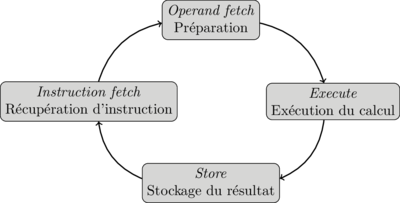

In [2]:
%%tikz

\tikzstyle{every node}=[text centered,align=center,fill=black!20,draw=black,rounded corners]
\tikzstyle{edgy}=[<-,thick,bend right]

\node (a) at (-3,0) {\emph{Instruction fetch} \\ Récupération d'instruction};
\node (b) at (0,2) {\emph{Operand fetch} \\ Préparation}
      edge [edgy] (a);
\node (c) at (3,0) {\emph{Execute} \\ Exécution du calcul}
     edge [edgy] (b);
\node (d) at (0,-2) {\emph{Store} \\ Stockage du résultat}
     edge [edgy] (c);
\draw (a) edge [edgy] (d);


Pour comprendre ce fonctionnement élémentaire, nous allons imaginer un ordinateur simplissime.

Cet ordinateur a 4 registres, des zones d'information pouvant contenir un entier et un seul.
Il a une mémoire, plus grande, dont chaque cas peut aussi contenir un entier.

Son unité arithmétique et logique est capable de faire trois opérations : addition, multiplication et soustraction.

Les seules instructions qu'il comprend sont donc:

| Instruction | Opérande 1|Opérande 2|Opérande 3|Signification    |
|-------------|-----------|----------|--------|-------------------|
|  STOP       |  - | - | - | Arrête la machine|
|  LOAD       | adresse A | N° reg. I| | R[I]←MEM[A] |
|  STORE      | adresse A | N° reg. I| | MEM[A]←R[I] |
|  PUT        | entier E  | N° reg. I| | R[I]←E |
|  ADD        | N° reg. I1 | N° reg. I2| N° reg. I3| R[I3]←R[I1]+R[I2]|
|  SUB        | N° reg. I1 | N° reg. I2| N° reg. I3| R[I3]←R[I1]-R[I2]|
|  MUL        | N° reg. I1 | N° reg. I2| N° reg. I3| R[I3]←R[I1]×R[I2]|
|  CPM0       | adresse d'instruction A | N° reg. I1| - | PC←A si R[I1]=0 |
|  GOTO       | adresse d'instruction A | - | - | PC←A |


Comment peut-on faire une addition simple de deux cases en mémoire (par exemple cases 0 et 1) ?

Il suffit d'utiliser le programme suivant :

    LOAD  %0 R1
    LOAD  %1 R2
    ADD   R1 R2 R3
    STORE %2 R3
    STOP

(pour clarifier, il a été rajouté un % devant les adresses et un R devant les numéros de registre)

Ce programme permet de charger depuis la mémoire les deux nombres dans les registres R1 et R2, de les additionner. Le résultat dans R3 est ensuite mis dans la case mémoire numéro 2.

Ce genre de langage est suffisamment simple pour être transcris en automatismes électroniques. Mais il est aussi suffisamment expressif pour permettre de faire des calculs compliqués. 

Le programme suivant permet de suivre le déroulement du programme tel qu'il se produit dans le processeur.

In [3]:
memi=[["LOAD","0","1"],["LOAD","1","2"],["ADD","1","2","3"],["STORE","2","3"],["STOP"]]

# Un programme pour calculer la factorielle de MEM[1]-1

memix=[
    ["PUT","1","1"],
    ["STORE","2","1"], # MEM[2]=1
    ["STORE","3","1"], # MEM[3]=1    
    ["LOAD","2","1"],  
    ["LOAD","3","2"],  
    ["MUL", "1", "2", "3"],
    ["STORE", "2", "3"], # MEM[2]←MEM[2]*MEM[3]
    ["PUT","1","1"],
    ["ADD","1","2","3"],
    ["STORE","3","3"],  # MEM[3]=MEM[3]+1
    ["LOAD","1","0"],
    ["SUB", "3", "0", "3"],
    ["CMP0", "14", "3"],      # IF MEM[2]==MEM[1], GOTO STOP
    ["GOTO","3"],
    ["STOP"]
 ]

# Décommentez les trois lignes suivantes pour faire factorielle(5)=5*4*3*2*1
# outputratio=1
# memi = memix
# mem[1]=6

In [4]:
next=0
step=0

r=[0,0,0,0]
pc=0

inst=['—']
val1=0
val2=0
result=0

phase="Booting"
mem=[2,4]+[0]*14
memi=[["LOAD","0","1"],["LOAD","1","2"],["ADD","1","2","3"],["STORE","2","3"],["STOP"]]


header='| Étape | Phase | R0 | R1 | R2 | R3 | INST | VAL1 | VAL2 | RESULT | MEM |'
headel='|-------|-------|----|----|----|----|------|------|------|--------|-----|'

out=[header,headel]
olda=[]

def output():
    global olda
    a=[]
    a.append(str(step))
    a.append(str(phase))
    a=a+[c for c in map(str,r)]
    a.append(' '.join(inst))
    a.append(str(val1))
    a.append(str(val2))
    a.append(str(result))
    lastnz=0
    for i in range(0,len(mem)):
        if mem[i]!=0:
            lastnz=i
    if lastnz+1==len(mem):
        a.append(','.join(mem))
    else:
        a.append(','.join(map(str,mem[:lastnz+1]))+'...')
    b=a.copy()
    for x in range(0,len(a)):
        if (len(olda)>0):
            if (olda[x]!=a[x]):
                b[x]='**'+a[x]+'**'
    olda=a.copy()
    l="|"+(" | ".join(b))+"|"
    out.append(l)
outputratio=4
output()

# LOAD PUT STORE ADD MUL SUB CMP0 GOTO
# LOAD charge depuis la mémoire dans un registre
# PUT met un entier dans un registre
# STORE met depuis un registre dans la mémoire
# ADD MUL et SUB font des opérations entre deux registres et mettent le résultat dans un registre
# CMP0 va à une adresse si deux registres sont égaux
# GOTO va a une adresse
# STOP arrête la machine

while True:
    step = step + 1
    phase="Instruction"
    inst=memi[pc]
    codeop=inst[0]
    if len(inst)>1:
        argone=inst[1]
    if len(inst)>2:
        argtwo=inst[2]
    if len(inst)>3:
        argthree=inst[3]
    else:
        argthree="-"
    if outputratio==4:
        output()
    phase="Preparation"
    if codeop=="LOAD":
        val1=mem[int(argone)]
    if codeop=="STORE":
        val1=r[int(argtwo)]
    if codeop=="ADD" or codeop=="SUB" or codeop=="MUL":
        val1=r[int(argone)]
        val2=r[int(argtwo)]
    if codeop=="PUT":
        val1=int(argone)
    if codeop=="GOTO":
        val1=int(argone)
    if codeop=="CMP0":
        val1=int(argone)
        val2=r[int(argtwo)]
    if codeop=="STOP":
        break
    if outputratio==4:
        output()
    phase="Execution"
    next=pc+1
    if codeop=="ADD":
        result=val1+val2
    if codeop=="SUB":
        result=val1-val2
    if codeop=="MUL":
        result=val1*val2
    if codeop=="LOAD" or codeop=="STORE" or codeop=="PUT":
        result=val1
    if codeop=="GOTO":
        next=val1
    if codeop=="CMP0":
        if val2==0:
            next=val1

    if outputratio==4:
        output()
    phase="Store"
    if codeop=="LOAD" or codeop=="PUT":
        r[int(argtwo)]=result
    if codeop=="STORE":
        mem[int(argone)]=result
    if codeop=="ADD" or codeop=="MUL" or codeop=="SUB":
        r[int(argthree)]=result
    pc=next
    output()
phase="Stop"
output()

def outputn(Step):
    u.mark('\n'.join(out[:(outputratio*Step+3)]))

if u.interactif:
    w=u.widgets.interactive(outputn, Step=(0,(len(out)-1)//outputratio))
    w.children[0].value=w.children[0].max
    w.children[0].description='Étape'
    display(w)
else:
    outputn((len(out)-1)//outputratio)


| Étape | Phase | R0 | R1 | R2 | R3 | INST | VAL1 | VAL2 | RESULT | MEM |
|-------|-------|----|----|----|----|------|------|------|--------|-----|
|0 | Booting | 0 | 0 | 0 | 0 | — | 0 | 0 | 0 | 2,4...|
|**1** | **Instruction** | 0 | 0 | 0 | 0 | **LOAD 0 1** | 0 | 0 | 0 | 2,4...|
|1 | **Preparation** | 0 | 0 | 0 | 0 | LOAD 0 1 | **2** | 0 | 0 | 2,4...|
|1 | **Execution** | 0 | 0 | 0 | 0 | LOAD 0 1 | 2 | 0 | **2** | 2,4...|
|1 | **Store** | 0 | **2** | 0 | 0 | LOAD 0 1 | 2 | 0 | 2 | 2,4...|
|**2** | **Instruction** | 0 | 2 | 0 | 0 | **LOAD 1 2** | 2 | 0 | 2 | 2,4...|
|2 | **Preparation** | 0 | 2 | 0 | 0 | LOAD 1 2 | **4** | 0 | 2 | 2,4...|
|2 | **Execution** | 0 | 2 | 0 | 0 | LOAD 1 2 | 4 | 0 | **4** | 2,4...|
|2 | **Store** | 0 | 2 | **4** | 0 | LOAD 1 2 | 4 | 0 | 4 | 2,4...|
|**3** | **Instruction** | 0 | 2 | 4 | 0 | **ADD 1 2 3** | 4 | 0 | 4 | 2,4...|
|3 | **Preparation** | 0 | 2 | 4 | 0 | ADD 1 2 3 | **2** | **4** | 4 | 2,4...|
|3 | **Execution** | 0 | 2 | 4 | 0 | ADD 1 2 3 | 2 | 4 | **6** | 2,4...|
|3 | **Store** | 0 | 2 | 4 | **6** | ADD 1 2 3 | 2 | 4 | 6 | 2,4...|
|**4** | **Instruction** | 0 | 2 | 4 | 6 | **STORE 2 3** | 2 | 4 | 6 | 2,4...|
|4 | **Preparation** | 0 | 2 | 4 | 6 | STORE 2 3 | **6** | 4 | 6 | 2,4...|
|4 | **Execution** | 0 | 2 | 4 | 6 | STORE 2 3 | 6 | 4 | 6 | 2,4...|
|4 | **Store** | 0 | 2 | 4 | 6 | STORE 2 3 | 6 | 4 | 6 | **2,4,6...**|
|**5** | **Instruction** | 0 | 2 | 4 | 6 | **STOP** | 6 | 4 | 6 | 2,4,6...|
|5 | **Stop** | 0 | 2 | 4 | 6 | STOP | 6 | 4 | 6 | 2,4,6...|

## Évolution des mécanismes

Évidemment, un langage aussi rudimentaire paraît ne pas pouvoir faire tout ce que l'on voit sur nos écrans.

Pourtant, c'est bien un langage assez similaire qui permet tous les usages actuels de l'informatique. Le cycle vital du processeur n'a que très peu de modifications.

Ce modèle correspond bien au fonctionnement d'un ordinateur qui exécute un unique programme. Mais de nos jours, ce n'est pas le cas ! La plupart des ordinateurs fonctionnent toujours avec un **processeur** et une **mémoire**, mais ils font tourner plusierurs programmes simultanément.

### Le pont fragile

Comment faire pour faire tourner plusieurs programmes simultanément ?

Racontons donc une petite histoire :

> Le pont de la mort est un pont très fragile. Il ne supporte que 65 kg de charge simultanée,
> et cassera après le premier passage de quelqu'un ou quelque chose dessus.
> L'acrobate pèse 63 kg, mais il voudrait passer avec 3 tonnelets d'un kg chacun.
> Les tonnelets ne peuvent pas être lancés directement d'un côté à l'autre du pont.
> **Comment peut-il faire ?**

Évidemment, cette énigme très connue a une solution simple : il suffit de jongler entre les différents tonnelets pour donner l'impression qu'il n'y a qu'un tonnelet au plus en même temps, et ainsi franchir le pont de la mort.

C'est le même genre de méthodes qui est utilisé pour donner l'illusion qu'un ordinateur fait tourner plusieurs programmes en même temps. Des mécanismes permettent, après un certain temps maximal, d'interrompre le déroulement normal d'un programme, de faire une copie des registres, et de passer à *autre chose* : un autre programme, par exemple, ou des tâches de gestion communes. Évidemment, ce mécanisme de gestion (à part la partie horloge qui signale le temps écoulé) dans le même langage rudimentaire. De plus, le système doit également s'assurer que lorsqu'un programme reprend ses fonctions, il récupère les bonnes données. C'est là qu'intervient le rôle du *système d'exploitation*, un programme exécuté par l'ordinateur pour gérer les interactions entre toutes les autres applications.


### Le système d'exploitation 

Le système d'exploitation **gère l'accès aux matériel de l'ordinateur** pour les applications. On peut distinguer trois grandes catégories de matériel:

  * les moyens de calcul (processeur, co-processeur, etc.)
  * la mémoire (mémoire RAM, mais aussi d'autres éléments)
  * les périphériques, qui eux-même peuvent être mis en trois groupes non exhaustif:
    * les périphériques de saisie ou d'affichage
    * les périphériques de communication
    * les périphériques de stockage

Le système d'exploitation a aussi un rôle (plus ou moins développé) de **fourniture d'interface unifiée aux applications** pour le contrôle des éléments ci-dessus, ainsi que pour des éléments d'interface communs à toutes les applications : *systèmes de fichiers*, *systèmes de communication*, *permissions des utilisateurs*, *interface graphique*.

Certains éléments parmi ces derniers sont parfois optionnels (ou substituables par d'autres) : par exemple, le système Linux, conçu par plusieurs équipes, a plusieurs systèmes d'interface graphique indépendants, et le cœur du système fournit une interface pour les interfaces graphiques plutôt qu'une interface graphique finalisée.

Pour les moyens de calcul, le système d'exploitation doit **gérer en particulier l'accès au processeur** par le partage de temps entre les applications (et le système proprement dit), notamment par le système des **interruptions** évoqué plus haut.

Pour la mémoire, il y a plusieurs tâches importantes mais le système d'exploitation doit gérer deux systèmes importants:
  * la réservation de la mémoire par le MMU (*Memory Management Unit*)
  * l'accès à la mémoire via l'adressage virtuel

La réservation de la mémoire consiste en l'attribution de zones de mémoire à chaque application à la demande, de tenir le compte de si elles sont occupées ou pas, et de les remettre libre lorsque l'application déclare ne plus en avoir besoin. L'adressage virtuel est une renumérotation de la mémoire pour permettre aux applications d'avoir l'impression qu'elles ont toutes la mémoire pour elles seules... tant qu'elles n'essayent pas de l'utiliser en entier.

Quant aux périphériques, ils sont contrôlés à deux niveaux : des fois de façon autonome par le matériel en utilisant une interface connue (par exemple le protocole USB) en parlant à un circuit spécialisé de l'ordinateur : *le contrôleur*, des fois de façon explicite entièrement guidé par le processeur, et le plus souvent par une combinaison des deux. Lorsqu'une partie logicielle doit être exécutée non pas par le processeur central, mais par le périphérique lui-même, on parle de *firmware*. Lorsqu'une partie logicielle doit être exécutée par le processeur central, on parle de *pilote* (ou *driver*). Par abus de langage, on confond parfois tous ces mots (les *pilotes* livrés avec un matériel comprennent aussi le firmware et même parfois des applications totalement indépendantes).

Les périphériques sont pilotés en deux modes d'interaction principaux selon leur autonomie et surtout leur vitesse de transfert. Les plus rapides sont en mode programmé avec un contrôleur évolué à qui on donne des ordres et qui agit de façon autonome ; le système vérifie périodiquement l'état de l'exécution pour savoir ce qui est terminé. Le plus lents sont en mode piloté par interruptions ; lorsqu'un transfert a lieu, le même mécanisme d'interruption qui sert à passer d'un applicatif à un autre permet de passer au système pour que celui-ci traite les données qui arrivent (ou doivent partir).

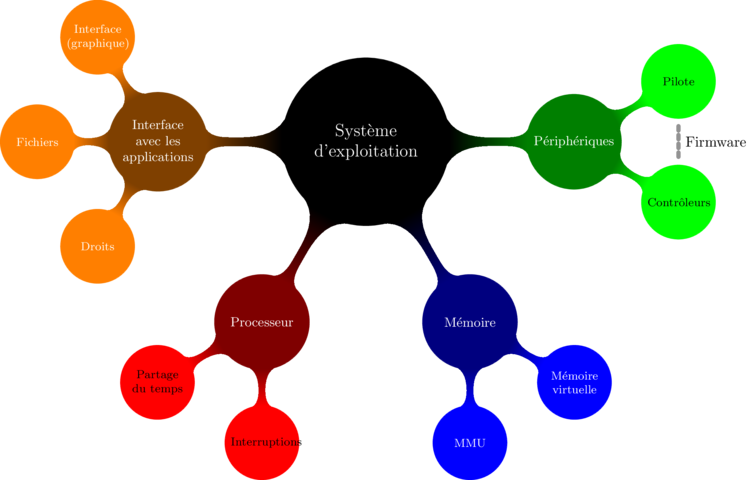

In [5]:
%%tikz -l mindmap,trees -s 800,480

\path[mindmap,concept color=black,text=white]
    node[concept] {Système d'exploitation}
    [clockwise from=0]
    child[concept color=green!50!black] {
        node[concept] {Périphériques}
        [clockwise from=30]
        child[concept color=green,text=black] { 
            node [concept] (p) {Pilote}
        }
        child[concept color=green,text=black] {
            node[concept] (c) {Contrôleurs}
        }
    }  
    child[concept color=blue!50!black] {
        node[concept] {Mémoire}
        [clockwise from=-30]
        child[concept color=blue] { node[concept] {Mémoire virtuelle} }
        child[concept color=blue] { node[concept] {MMU} }
    }
    child[concept color=red!50!black,text=white] {
        node[concept] {Processeur}
        [clockwise from=-90]
        child[concept color=red,text=black] { node[concept] {Interruptions} }
        child[concept color=red,text=black] { node[concept] {Partage du temps} }
    }
    child[concept color=orange!50!black,text=white] {
        node[concept] {Interface avec les applications}
        [counterclockwise from=120]
        child[concept color=orange,text=white] { node[concept] {Interface (graphique)} }
        child[concept color=orange,text=white] { node[concept] {Fichiers} }
        child[concept color=orange,text=white] { node[concept] {Droits} }
    };
\draw [concept connection, dashed]  (p) edge[auto] node {Firmware} (c);

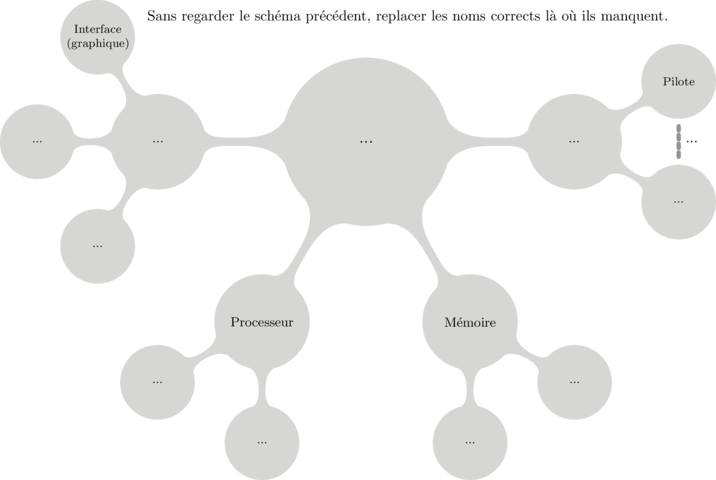

In [6]:
%%tikz -l mindmap,trees -s 800,480

  % Remplacer les ... par les noms corrects, sans regarder le schéma ci-dessus !

\node at (1,3) {Sans regarder le schéma précédent, replacer les noms corrects là où ils manquent.};
\path[mindmap,concept color=black!20,text=black]
    node[concept] {...}
    [clockwise from=0]
    child {
        node[concept] {...}
        [clockwise from=30]
        child { 
            node [concept] (p) {Pilote}
        }
        child {
            node[concept] (c) {...}
        }
    }  
    child {
        node[concept] {Mémoire}
        [clockwise from=-30]
        child { node[concept] {...} }
        child { node[concept] {...} }
    }
    child {
        node[concept] {Processeur}
        [clockwise from=-90]
        child { node[concept] {...} }
        child { node[concept] {...} }
    }
    child {
        node[concept] {...}
        [counterclockwise from=120]
        child { node[concept] {Interface (graphique)} }
        child { node[concept] {...} }
        child { node[concept] {...} }
    };
\draw [concept connection, dashed]  (p) edge[auto] node {...} (c);

Pour un bon fonctionnement, les systèmes d'exploitation modernes se sont dotés de plusieurs fonctionnalités indispensables:

  * Un fonctionnement avec un noyau central. Le noyau est le code du système d'exploitation qui supervise le fonctionnement. On fait la distinction avec d'autres systèmes moins importants (le gestionnaire d'interface graphique par exemple) qui font partie de ce qui est fourni avec le système d'exploitation.
  * Un *bootloader* ou *système d'amorçage* est le programme primaire exécuté au démarrage de l'ordinateur. Son rôle, outre l'initialisation de certains sous-systèmes, est de lancer le noyau.
  * Quelques fonctionnalités au niveau du matériel :
    * Un système d'interruptions déjà évoqué qui permet en cas d'événement matériel (horloge, arrivée de données) de reprendre la main. Le compteur de programme change alors de valeur
    * Le système de mémoire virtuelle qui permet de rajouter une couche d'indirection pour lire une adresse mémoire
    * Différents niveaux d'exécution (mode noyau/mode utilisateur) qui permettent de protéger le système de mémoire virtuelle dans certains modes : du coup certains segments de la mémoire deviennent inaccessibles dans les modes moins privilégiés.
    * Divers niveaux de protection de la mémoire (en mode utilisateur): 
      * zone de mémoire ne pouvant contenir que des données, pas d'instructions
      * zone de mémoire ne pouvant pas être modifiée
      * zone de mémoire ne pouvant pas être lue
  * Des systèmes d'entrée/sortie qui peuvent directement écrire ou lire dans la mémoire sans mobiliser le processeur.
  * Enfin, selon la définition d'un système d'exploitation, il y a des logiciels supplémentaires :
    * Un environnement d'exécution (*runtime*)
    * Un environnement de développement logiciel
    * Une ou plusieurs interfaces utilisateur (interfaces graphiques ou texte)
    * Une série d'applications considérées comme plus ou moins indispensable à tout utilisateur.
  
Tout ceci sera revu plus en détail dans le cours de *programmation bas-niveau*.

### Les interruptions

Les interruptions sont un mécanisme de bas niveau qui est indispensable au fonctionnement correct de l'ordinateur.

Le traitement d'une interruption se fait toujours en commençant par sauvegarder à un endroit spécifique l'état interne du processeur (état des registres). Une table stockée en mémoire indique à quelle adresse est la procédure de traitement de l'interruption. Lorsque le traitement de l'interruption est terminé, on retourne au code principal... sauf si le traitement de l'interruption a modifié l'adresse de retour, ce qui est ce qui se passe lorsque l'on veut changer de tâche : on exécute la tâche A, on est interrompu à l'adresse 100 000 (par exemple), et au lieu de remettre 100 000 dans le compteur de programme à la fin du traitement de l'interruption, on met 200 000 (qui est au milieu du programme de la tâche B). Au bout d'un moment, la tâche B est elle aussi interrompue, et après un certain temps, on remet 100 000 comme adresse de retour, ce qui permet de revenir à la tâche A. Du point de vue de la tâche A, l'interruption est indétectable, à part en regardant l'horloge réelle de temps en temps.

Évidemment, lorsqu'on change de tâche, il faut non seulement restaurer une adresse d'exécution différente, mais aussi bien sauvegarder les registres et les remettre à l'identique. Des zones spéciales de la mémoire sont utilisées pour ça.

Les interruptions sont de deux types:
  * Chronomètres : après un temps donné, une interruption se déclenche
  * Par instruction : une instruction spécifique permet de déclencher une interruption
  * Matérielles : lorsqu'un périphérique ou un autre élément de l'ordinateur émet un signal d'interruption, le processeur est alerté (le circuit électronique est conçu comme ceci) et peut décider de traiter l'interruption au moment opportun (selon la façon dont le circuit est fait).


Les interruptions ont deux usages fondamentaux :
  * Changer de tâche (on appelle ça la *commutation de tâches*)
  * Traiter l'envoi ou la réception de données en provenance des périphériques
  * Exécuter du code qui n'est pas prévu si le système est mal pensé, en autorisant le traitement de l'interruption à modifier les zones de sauvegarde.

Dernier point basique sur les interruptions : certaines interruptions non-indispensables sont masquables, c'est-à-dire qu'on peut dire au processeur de les ignorer. Elles ne le sont pas toutes évidemment, pour garantir un bon fonctionnement du processeur.

Le code de traitement des interruptions est exécuté dans le mode d'exécution avec des droits plus élevés, puisqu'il est nécessaire de faire des opérations inhabituelles.

### Les niveaux de fonctionnement

Pour permettre d'isoler tout ces programmes qui s'exécutent en même temps, et pour optimiser l'utilisation du matériel, les systèmes d'exploitation moderne travaillent dans plusieurs modes. Un mode central, celui au démarrage, permet de tout faire. Un mode plus restreint permet de faire moins de choses, un certain nombre d'instructions ou de combinaisons instruction+certaines valeurs sont interdites. Ce mode dégradé est appelé mode utilisateur, et c'est le mode le plus utilisé.

#### Pourquoi un mode restreint ?

  * garantir **l'étanchéité** entre les différentes tâches exécutées par le processeur
  * assurer **la cohérence** de la lecture de données dans les périphériques
  * améliorer **l'efficacité** de l'utilisation du processeur et de la mémoire

Pour chacun de ces exemples, il est facile d'imaginer un scénario où une autorité centrale est requise. Cette autorité centrale c'est une partie des instructions du *noyau*. Pour éviter les bugs, il convient d'utiliser le moins possible ce mode lorsqu'il n'est pas nécessaire d'y être. Pour effectuer les opérations nécessitant des privilèges, le programme en mode utilisateur va faire un *appel système*.

Le passage d'un mode à l'autre se fait par une interruption qui place le système en mode privilégié puis changement du programme exécuté pour un morceau de code très fiable qui gère la requête (le gestionnaire d'appel système). Ce morceau de code effectue sa tâche en mode privilégié, puis se termine pour rendre la main au programme d'origine (ou, bien souvent, à un autre programme, pour faire tourner plus vite les applications). Par exemple, l'appel système `write` va écrire des données sur un périphérique, puis rendre la main.

En théorie, seul le code qui a besoin d'être privilégié est exécuté en mode privilégié. Toutefois, pour des raisons de performance, certaines parties des opérations du noyau sont exécutées en mode privilégié pour éviter les allers-retours entre les différents modes.

Un appel système a typiquement un coût de changement d'environ 1000 à 1500 cycles, ce qui n'est pas négligeable.



In [7]:
u.activite('Interruptions')
u.mark('Donnez un exemple de pourquoi dans la plupart des cas il ne faut pas que toutes les interruptions soient masquables simultanément.')
u.solution('Une application qui masquerait l´interruption correspondant au changement de tâche pourrait garder le contrôle du processeur pendant un temps indéterminé. De plus, si on masque l´arrivée de données et que dans le même temps, on attend que les données arrivent, on arriverait à une situation verrouillée et inextricable (deadlock).')


#### Activité : Interruptions

Donnez un exemple de pourquoi dans la plupart des cas il ne faut pas que toutes les interruptions soient masquables simultanément.

Votre proposition > `_____________________________________________________`

**Solution:** Une application qui masquerait l´interruption correspondant au changement de tâche pourrait garder le contrôle du processeur pendant un temps indéterminé. De plus, si on masque l´arrivée de données et que dans le même temps, on attend que les données arrivent, on arriverait à une situation verrouillée et inextricable (deadlock).

In [8]:
u.activite('Niveaux de fonctionnement')
u.mark('**La plupart des systèmes d´exploitation utilisent deux modes de fonctionnement (noyau et utilisateur), l´un des modes n´ayant pas les droits de faire certaines opérations. Lequel ?**')
x=u.solutioncheck('Votre proposition [noyau/utilisateur]','noyau','Tout à fait !','Le mode noyau est le mode qui a les droits les plus élevés. L´utilisateur normal a des droits restreints (par exemple, il ne peut pas écraser n´importe quelle donnée par une autre, y compris en dehors de son périmètre attribué).')

questions=['Passer du mode utilisateur au mode système',
    'Lire l´horloge',
    'Modifier la table d´état des périphériques',
    'Effacer des blocs de mémoire',
    'Déclencher une interruption',
    'Accéder aux entrées/sortie d´un périphérique',
    'Bloquer temporairement les interruptions',
    'Changer la valeur d´une interruption basée sur le temps.']
answers = 236

u.mark('**Voici des actions : pour chacune, dites si elle doit a priori être effectuée en mode (p)rivilégié ou n´importe (q)uel mode.**')
num=0
fail=0
x=1
for question in questions:
    rep='q'
    if x & answers:
        rep='p'
    if u.solutioncheck(question+' [pq]',rep,'Bravo','Eh non !'):
        num=num+1
    else:
        fail=fail+1
    x=x+x
u.mark('**Vous avez répondu correctement à {0} questions sur {1}.**'.format(num,num+fail))

#### Activité : Niveaux de fonctionnement

**La plupart des systèmes d´exploitation utilisent deux modes de fonctionnement (noyau et utilisateur), l´un des modes n´ayant pas les droits de faire certaines opérations. Lequel ?**

Votre proposition [noyau/utilisateur] > `_____________________________________________________`

**Solution :** noyau

**Voici des actions : pour chacune, dites si elle doit a priori être effectuée en mode (p)rivilégié ou n´importe (q)uel mode.**

Passer du mode utilisateur au mode système [pq] > `_____________________________________________________`

**Solution :** q

Lire l´horloge [pq] > `_____________________________________________________`

**Solution :** q

Modifier la table d´état des périphériques [pq] > `_____________________________________________________`

**Solution :** p

Effacer des blocs de mémoire [pq] > `_____________________________________________________`

**Solution :** p

Déclencher une interruption [pq] > `_____________________________________________________`

**Solution :** q

Accéder aux entrées/sortie d´un périphérique [pq] > `_____________________________________________________`

**Solution :** p

Bloquer temporairement les interruptions [pq] > `_____________________________________________________`

**Solution :** p

Changer la valeur d´une interruption basée sur le temps. [pq] > `_____________________________________________________`

**Solution :** p

**Vous avez répondu correctement à 0 questions sur 8.**

In [9]:
u.activite('Mémoire très protégée')
u.mark('Certains anciens systèmes d´exploitation protégeaient le système d´exploitation contre les erreurs en divisant la mémoire en deux : une partie qui contenait le système et qui ne pouvait pas être modifiée du tout, et le reste de la mémoire accessible à tous. Donner un ou plusieurs inconvénients d´un tel système de protection.')
u.solution('Dans ce modèle, les données sensibles stockées dans la mémoire ne pourraient qu´être dans le segment de mémoire commun, et donc ne pourraient pas être protégées de la lecture par une application utilisateur.')

#### Activité : Mémoire très protégée

Certains anciens systèmes d´exploitation protégeaient le système d´exploitation contre les erreurs en divisant la mémoire en deux : une partie qui contenait le système et qui ne pouvait pas être modifiée du tout, et le reste de la mémoire accessible à tous. Donner un ou plusieurs inconvénients d´un tel système de protection.

Votre proposition > `_____________________________________________________`

**Solution:** Dans ce modèle, les données sensibles stockées dans la mémoire ne pourraient qu´être dans le segment de mémoire commun, et donc ne pourraient pas être protégées de la lecture par une application utilisateur.

In [10]:
u.activite('Cycles et instructions')

instmem=2
timemem=random.choice([20,25,30])
instother=3
timeother=1
freq=random.choice([2.0,2.5,4.0])

u.mark('On se place dans un modèle simplifié où chaque cycle du processeur permet d´exécuter une et\
 une seule instruction (notez bien que dans les processeurs modernes, plus complexes, ce n´est plus le cas).\
 Les instructions d´accès à la mémoire centrale prennent plus de temps, {1} cycles en tout (la mémoire centrale\
 est plus lente que le processeur).\
\n\
L´horloge du processeur fonctionne à {0} GHz.\n\
\n\
Un programme simple parcourt un tableau en faisant les opérations suivantes :\n\
\n\
  1. Lire une donnée en mémoire à une adresse *i*\n\
  2. Multiplier par deux la donnée\n\
  3. Écrire le résultat à la même place\n\
  4. Ajouter 1 au compteur *i*\n\
  5. Si _i_ n´a pas atteint une valeur limite, retourner en **1**'.format(u.n2s(freq),timemem))

rep=instmem*timemem+instother*timeother
x=u.solutioncheck('Combien de cycles sont nécessaires pour faire une boucle complète ?',str(rep),'Tout à fait !','C´est ${0}\\times {1}+{2}\\times {3}={4}$, car il y a {0} instructions d´accès à la mémoire centrale et {2} autres instructions par boucle.'.format(instmem,timemem,instother,timeother,rep))
num=random.choice([100,1000,200,100,1000])
elemtime=int(num*rep/freq)
x=u.solutioncheck('Combien de temps est nécessaire pour parcourir un tableau de {0} éléments en nanosecondes ?'.format(num),str(elemtime),'Bravo','Le nombre de cycle est ${0}\\times{1}={2}$, et donc le temps est ${2}/{3}={4}$ ns.'.format(u.n2s(num),u.n2s(rep),u.n2s(num*rep),u.n2s(freq),u.n2s(elemtime)))

#### Activité : Cycles et instructions

On se place dans un modèle simplifié où chaque cycle du processeur permet d´exécuter une et une seule instruction (notez bien que dans les processeurs modernes, plus complexes, ce n´est plus le cas). Les instructions d´accès à la mémoire centrale prennent plus de temps, 20 cycles en tout (la mémoire centrale est plus lente que le processeur).
L´horloge du processeur fonctionne à 4 GHz.

Un programme simple parcourt un tableau en faisant les opérations suivantes :

  1. Lire une donnée en mémoire à une adresse *i*
  2. Multiplier par deux la donnée
  3. Écrire le résultat à la même place
  4. Ajouter 1 au compteur *i*
  5. Si _i_ n´a pas atteint une valeur limite, retourner en **1**

Combien de cycles sont nécessaires pour faire une boucle complète ? > `_____________________________________________________`

**Solution :** 43

Combien de temps est nécessaire pour parcourir un tableau de 200 éléments en nanosecondes ? > `_____________________________________________________`

**Solution :** 2150

## Bonus : les caractères

Un certain nombre de caractères sont utilisés en informatique, mais ne sont pas employés dans le langage courant.

| Notation « C » | Nom usuel | Noms français | Noms anglais |
|--------------------------|-----------|---------------|--------------|
| # | dièse | croisillon, octothorpe | hash, number sign |
| & | et | esperluette, et commercial | ampersand, and |
| &#x7C; | ou, *païpe* | barre vertical | pipe |
| / | slash | barre oblique | slash |
| \ | backslash | barre contre-oblique, antislash | backslash |
| _ | underscore | (blanc) souligné, *tiret du bas* | underscore |
| &#x5B; &#x5D; | crochets | crochets | (square) brackets |
| &#x7B; &#x7D; | accolades | accolades | (curly) braces |
| @ | *arobase* | arobase, a commercial | at (sign) |
| * | étoile | étoile, multiplier | star (sign) |
| ! | point d'exclamation | point d'exclamation | exclamation mark, bang |
| \n | nouvelle ligne | nouvelle ligne, retour à la ligne | newline |
| \r | retour chariot | retour chariot | carriage return |
| \t | tabulation | tabulation, tab | tab |
| &#x20; | espace | espace, blanc | space |
| ' | apostrophe | apostrophe (droite) | quote |
| &#x60; | backquote | apostrophe inversée | backquote |
| " | guillemet | guillemet (droit) | double quote |
| ' | apostrophe | apostrophe (droite) | quote |
| « » | guillemet (français) | guillemet (français), double chevron | double chevrons, french guillemets |
| ´ | apostrophe (courbe) | apostrophe (courbe) | right single quotation mark |


## Bonus : les touches

  * En haut à gauche du clavier : *escape* ou *échappement*
  * À gauche, ligne des chiffres : *carré*
  * À gauche, ligne AZERTY : *TAB*
  * À gauche, ligne QSDFG : *CAPS LOCK* ou *verrouillage majuscules*
  * À gauche, ligne WXCV : *Shift* ou *majuscules*
  * À gauche de la barre d'espace, dans un ordre variable : *contrôle*, *meta*, *alt*, parfois *fonction*
  * À droite de la barre d'espace, dans un ordre variable : *altgraph* ou *alt-g-r*, *contrôle*, *menu*
  * À droite en général sur AZERTY et QSDFG : *entrée*
  * À droite ligne des chiffres : *retour arrière* (ne fait pas toujours la même chose que *supprime*)
  * À droite du P : *touche morte* pour faire les accents circonflexes et les trémas
  * Pas sur tous les claviers, mais sur la plupart : touches de fonction *F1* à *F12*, touche *mode d'insertion*, touche d'*impression écran*, touche *pause*, touche *début*, touche *fin*, touche *supprime*, touches *page UP* *page DOWN* (ou *page précédente* et *page suivante*), ainsi que le pavé numérique avec *verrouillage numérique*.


In [11]:
u.xtoggle()

Mode interactif
